In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import t, beta as b, gamma
import pymc3 as pm
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)
import arviz as az
import statsmodels.api as sm
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import StackingRegressor
from functools import reduce
import shap
shap.initjs()

## Table of Contents:

3. [Statistical tests](#statistical-tests)
    - [T-test](#t-test)
        - [All companies](#t-test-overall)
        - [Large companies](#t-test-large)
        - [Medium companies](#t-test-medium)
        - [Small companies](#t-test-small)
    - [Bayesian statistics](#bayesian-statistics)
        - [All companies](#bayesian-overall)
        - [Large companies](#bayesian-large)
        - [Medium companies](#bayesian-medium)
        - [Small companies](#bayesian-small)

# 3. Statistical tests <a class="anchor" id="statistical-tests"></a>

# 3.1. T-test to validate the statistical significance <a class="anchor" id="t-test"></a>


In [37]:
tmp1 = df2.groupby(['treatment','company_size']).mean()['over_one_percent'].reset_index()
print('='*45, '\n >1% overspend campaign probability \n', '='*45)
pd.pivot_table(
    tmp1, values=['over_one_percent'], index='company_size', 
    columns='treatment', aggfunc='mean').transpose()[:2]

 >1% overspend campaign probability 


company_size                large  medium  small
                 treatment                      
over_one_percent False       0.69    0.61   0.79
                 True        0.62    0.60   0.71

In [38]:
tmp2 = df2.groupby(['treatment','company_size']).mean()['overspend_ratio'].reset_index()
print('='*45, '\n Average overspend ratio per campaign \n', '='*45)
pd.pivot_table(
    tmp2, values=['overspend_ratio'], index='company_size', 
    columns='treatment', aggfunc='mean').transpose()[:2]

 Average overspend ratio per campaign 


company_size               large  medium  small
                treatment                      
overspend_ratio False       0.19    0.13   0.42
                True        0.13    0.15   0.35

In [39]:
def t_test(group1, group2, metric, test, alternative, title, alpha=0.02):
    '''
    Manual two samples t-test for proportion and mean
    
    Parameters:
    - group1: control group (dataframe)
    - group2: treatment group (dataframe)
    - metric: metric to test (text)
    - test: test type, proportion or mean (text)
    - side: tail to chose (text)
    - title: title of the test (text)
    - alpha: significance level
    
    Return:
    - Summary of parametors
    - Statisitcal conclusion
    '''
    
    # Step 1: Calc the proportions of provided datasets, delta, and standard error
    n_c = group1[metric].count()
    n_t = group2[metric].count()
    
    if test == 'proportion':
        p_c = group1[metric].sum() / n_c
        p_t = group2[metric].sum() / n_t
        delta = p_t - p_c
        p = (group1[metric].sum() + group2[metric].sum()) / (n_c+n_t)
        se = np.sqrt((p*(1-p)) * (1/n_c+1/n_t))
        
    elif test == 'mean':
        p_c = group1[metric].mean()
        p_t = group2[metric].mean()
        delta = p_t - p_c
        std_c = np.sqrt(np.var(group1[metric], ddof=1))
        std_t = np.sqrt(np.var(group2[metric], ddof=1))
        std_p = np.sqrt(((n_c-1) * std_c**2 + (n_t-1)*std_t**2) / (n_c+n_t-2))
        se = std_p * np.sqrt(1/n_c+1/n_t)

    # Step 2: Calc t-statistic, critical value, confidence interval, and p-value
    t_stat = delta / se
    dof = (n_c+n_t-2)
    critical_val = scipy.stats.t.ppf(1-alpha, df=dof) # one side critical value
    p_val = round(1 - scipy.stats.t.cdf(abs(t_stat), df=dof), 3)
    
    if alternative == 'less':
        p_val = round(scipy.stats.t.cdf(t_stat, df=dof), 3)
        conf_int = ["-∞", round(delta+(critical_val*se), 3)]
    elif alternative == 'greater':
        p_val = round(1 - scipy.stats.t.cdf(t_stat, df=dof), 3)
        conf_int = [round(delta+(critical_val*se), 3), "∞"]
    elif alternative == 'two-sided':
        p_val = (1 - scipy.stats.t.cdf(abs(t_stat), df=dof)) * 2
        conf_int = [round(delta-(critical_val*se), 3), round(delta+(critical_val*se), 3)]

    # Step 3: Summarize the analysis and output the conclusion
    print('-' * 52)
    print(f'T-test: {title}')
    print('-' * 52, '\n')   
    print('-' * 22, 'Result', '-' * 22)
    print(f'Control: {round(p_c, 3)}')
    print(f'Treatment: {round(p_t, 3)}')
    print(f'Delta: {round(delta, 3)}')     
    print(f'Standard error: {round(se, 3)}')
    print(f'T-statistic: {round(t_stat, 3)}')
    print(f'Critical value: {round(critical_val, 3)}')
    print(f'P-value: {p_val}')
    print(f'Alpha: {alpha}')
    
    if p_val < alpha:
        print('\nReject the null hypothesis.')
    else:
        print('\nFail to reject the null hypothesis.')

## All companies <a class="anchor" id="t-test-overall"></a>

In [40]:
t_test(cont, treat, 'over_one_percent', 'proportion', 'less', 
       'All companies overspend campaign proportion', alpha=0.05)

----------------------------------------------------
T-test: All companies overspend campaign proportion
---------------------------------------------------- 

---------------------- Result ----------------------
Control: 0.739
Treatment: 0.669
Delta: -0.07
Standard error: 0.007
T-statistic: -9.533
Critical value: 1.645
P-value: 0.0
Alpha: 0.05

Reject the null hypothesis.


In [41]:
t_test(cont, treat, 'overspend_ratio', 'mean', 'less', 'All companies average overspend ratio')

----------------------------------------------------
T-test: All companies average overspend ratio
---------------------------------------------------- 

---------------------- Result ----------------------
Control: 0.313
Treatment: 0.259
Delta: -0.054
Standard error: 0.011
T-statistic: -4.967
Critical value: 2.054
P-value: 0.0
Alpha: 0.02

Reject the null hypothesis.


In [42]:
t_test(cont, treat, 'campaign_budget', 'mean', 'two-sided', 'All companies average budget')

----------------------------------------------------
T-test: All companies average budget
---------------------------------------------------- 

---------------------- Result ----------------------
Control: 4641.828
Treatment: 5350.744
Delta: 708.917
Standard error: 855.598
T-statistic: 0.829
Critical value: 2.054
P-value: 0.4073647671463272
Alpha: 0.02

Fail to reject the null hypothesis.


## Large companies <a class="anchor" id="t-test-large"></a>

In [43]:
t_test(cl, tl, 'over_one_percent', 'proportion', 'less', 'Large companies overspend campaign proportion')

----------------------------------------------------
T-test: Large companies overspend campaign proportion
---------------------------------------------------- 

---------------------- Result ----------------------
Control: 0.694
Treatment: 0.615
Delta: -0.079
Standard error: 0.013
T-statistic: -5.956
Critical value: 2.054
P-value: 0.0
Alpha: 0.02

Reject the null hypothesis.


In [44]:
t_test(cl, tl, 'overspend_ratio', 'mean', 'less', 'Large companies average overspend ratio')

----------------------------------------------------
T-test: Large companies average overspend ratio
---------------------------------------------------- 

---------------------- Result ----------------------
Control: 0.193
Treatment: 0.129
Delta: -0.064
Standard error: 0.013
T-statistic: -5.111
Critical value: 2.054
P-value: 0.0
Alpha: 0.02

Reject the null hypothesis.


In [45]:
t_test(cl, tl, 'campaign_budget', 'mean', 'two-sided', 'Large companies average budget')

----------------------------------------------------
T-test: Large companies average budget
---------------------------------------------------- 

---------------------- Result ----------------------
Control: 5933.969
Treatment: 12655.707
Delta: 6721.738
Standard error: 2163.16
T-statistic: 3.107
Critical value: 2.054
P-value: 0.0018979008624264715
Alpha: 0.02

Reject the null hypothesis.


## Medium companies <a class="anchor" id="t-test-medium"></a>

In [46]:
t_test(cm, tm, 'over_one_percent', 'proportion', 'less', 'Medium companies overspend campaign proportion')

----------------------------------------------------
T-test: Medium companies overspend campaign proportion
---------------------------------------------------- 

---------------------- Result ----------------------
Control: 0.615
Treatment: 0.598
Delta: -0.017
Standard error: 0.026
T-statistic: -0.645
Critical value: 2.056
P-value: 0.259
Alpha: 0.02

Fail to reject the null hypothesis.


In [47]:
t_test(cm, tm, 'overspend_ratio', 'mean', 'less', 'Medium companies average overspend ratio')

----------------------------------------------------
T-test: Medium companies average overspend ratio
---------------------------------------------------- 

---------------------- Result ----------------------
Control: 0.129
Treatment: 0.149
Delta: 0.02
Standard error: 0.02
T-statistic: 1.042
Critical value: 2.056
P-value: 0.851
Alpha: 0.02

Fail to reject the null hypothesis.


In [48]:
t_test(cm, tm, 'campaign_budget', 'mean', 'less', 'Medium companies average budget')

----------------------------------------------------
T-test: Medium companies average budget
---------------------------------------------------- 

---------------------- Result ----------------------
Control: 6342.855
Treatment: 4612.671
Delta: -1730.184
Standard error: 1510.173
T-statistic: -1.146
Critical value: 2.056
P-value: 0.126
Alpha: 0.02

Fail to reject the null hypothesis.


## Small companies <a class="anchor" id="t-test-small"></a>

In [49]:
t_test(cs, ts, 'over_one_percent', 'proportion', 'less', 'Small companies overspend campaign proportion')

----------------------------------------------------
T-test: Small companies overspend campaign proportion
---------------------------------------------------- 

---------------------- Result ----------------------
Control: 0.789
Treatment: 0.709
Delta: -0.08
Standard error: 0.009
T-statistic: -8.697
Critical value: 2.054
P-value: 0.0
Alpha: 0.02

Reject the null hypothesis.


In [50]:
t_test(cs, ts, 'overspend_ratio', 'mean', 'less', 'Small companies average overspend ratio')

----------------------------------------------------
T-test: Small companies average overspend ratio
---------------------------------------------------- 

---------------------- Result ----------------------
Control: 0.42
Treatment: 0.345
Delta: -0.075
Standard error: 0.017
T-statistic: -4.47
Critical value: 2.054
P-value: 0.0
Alpha: 0.02

Reject the null hypothesis.


In [51]:
t_test(cs, ts, 'campaign_budget', 'mean', 'two-sided', 'Small companies average budget')

----------------------------------------------------
T-test: Small companies average budget
---------------------------------------------------- 

---------------------- Result ----------------------
Control: 3538.656
Treatment: 1585.48
Delta: -1953.176
Standard error: 764.954
T-statistic: -2.553
Critical value: 2.054
P-value: 0.010686568319221879
Alpha: 0.02

Reject the null hypothesis.


# 3.2. Bayesien statistics <a class="anchor" id="bayesian"></a>

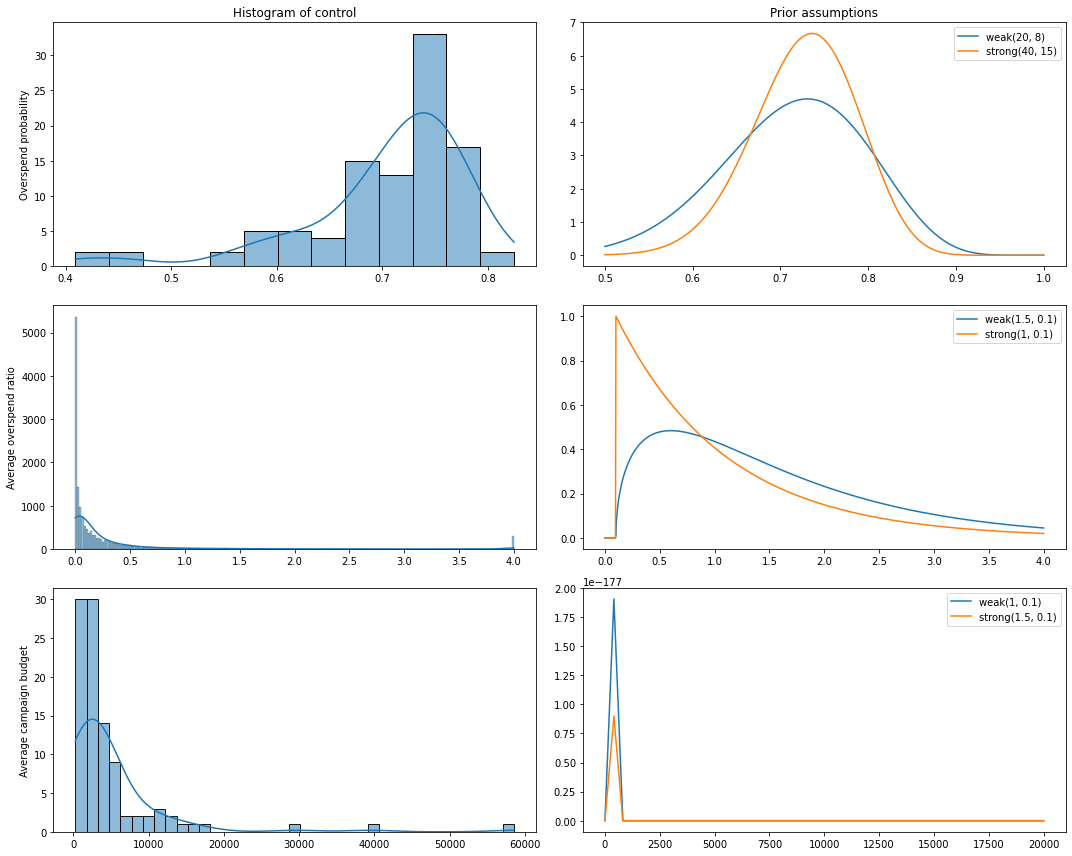

In [52]:
# Check the distribution of indicators to choose prior and likelihood function
partitions = np.array_split(df2, 100)
prob_o = []
for p in partitions:
    prob_o.append(p['over_one_percent'].mean())

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(15, 12))

sns.histplot(prob_o, kde=True, ax=ax[0,0])
ax[0,0].set_title('Histogram of control')
ax[0,0].set_ylabel('Overspend probability')

# Bernoulli distribution with Beta for overspend probability
x = np.linspace(0.5, 1, 1000)
weak, strong = b(20, 8), b(40, 15)
ax[0,1].plot(x, weak.pdf(x), label=f'weak({20}, {8})')
ax[0,1].plot(x, strong.pdf(x), label=f'strong({40}, {15})')
ax[0,1].set_title('Prior assumptions')
ax[0,1].legend()


sns.histplot(df2.overspend_ratio, kde=True, ax=ax[1,0])
ax[1,0].set_ylabel('Average overspend ratio')
ax[1,0].set_xlabel('')

# Poisson distribution with Gamma for overspend ratio
x = np.linspace(0, 4, 1000)
weak, strong = gamma(1.5, 0.1), gamma(1, 0.1)
ax[1,1].plot(x, weak.pdf(x), label=f'weak({1.5}, {0.1})')
ax[1,1].plot(x, strong.pdf(x), label=f'strong({1}, {0.1})')
ax[1,1].legend()


partitions = np.array_split(df2, 100)
mean_b = []
for p in partitions:
    mean_b.append(p['campaign_budget'].mean())

sns.histplot(mean_b, kde=True, ax=ax[2,0])
ax[2,0].set_ylabel('Average campaign budget')

# Poisson distribution with Gamma for budget
x = np.linspace(0,20000,50)
weak, strong = gamma(1.1, 0.6), gamma(1, 0.5)
ax[2,1].plot(x, weak.pdf(x), label=f'weak({1}, {0.1})')
ax[2,1].plot(x, strong.pdf(x), label=f'strong({1.5}, {0.1})')
ax[2,1].legend()

plt.tight_layout()

In [53]:
def bayesian_ab(group1, group2, metric, distribution, winning_method, title):
    '''
    Bayesian statistic calculation for overspend probability and ratio
    
    Parameters:
    - group1: control group (dataframe)
    - group2: treatment group (dataframe)
    - metric: to test (text)
    - distribution: type of posterior distribution, bernoulli or poisson (text)
    - winning_method: reduce or increase metric over control (text)
    - title: title of the test (text)
    
    Return:
    - Posterior distributions, delta vs control, probability of winning vs control, and expected loss
    ''' 
    # Step 1: Set parameters, prior, likelihood function, and draw posterior for both control and treatment
    if distribution == 'bernoulli':
        with pm.Model() as model:
            alpha = pm.Uniform("alpha", lower=0, upper=100)
            beta = pm.Uniform("beta", lower=0, upper=100)
            control = pm.Beta('control', alpha=alpha, beta=beta)
            treatment = pm.Beta('treatment', alpha=alpha, beta=beta)
            control_like = pm.Bernoulli('control_like', p=control, observed=group1[metric])
            treatment_like = pm.Bernoulli('treatment_like', p=treatment, observed=group2[metric])
            
    elif distribution == 'poisson':
        with pm.Model() as model:
            k = pm.Uniform("k", lower=0, upper=5)
            theta = pm.Uniform("theta", lower=0, upper=5)
            control = pm.Gamma('control', alpha=k, beta=theta)
            treatment = pm.Gamma('treatment', alpha=k, beta=theta)
            control_like = pm.Poisson('control_like', control, observed=group1[metric])
            treatment_like = pm.Poisson('treatment_like', treatment, observed=group2[metric])
            
    with model:
        improvement = pm.Deterministic('improvement', treatment - control)
        # draw samples from posterior distribution with 95% acceptance ratio
        trace = pm.sample(2000, tune=10000, target_accept=0.95, chains=4, step=[pm.Metropolis(), pm.NUTS()])
        summary = pm.summary(trace)
        
     
    # Step 2: Calc winning probability over control and expected losses
    L = list(zip(trace['treatment'], trace['control']))
    n_c, n_t = group1[metric].count(), group2[metric].count()
    
    if winning_method == 'reduce':
        wins = trace['treatment'] < trace['control']
        loss_c = map(lambda L: np.max([L[1]-L[0], 0]), L)
        loss_t = map(lambda L: np.max([L[0]-L[1], 0]), L)
        loss_sum_c = reduce(lambda i, j : i+j, loss_c)
        exp_loss_c = loss_sum_c / n_c
        loss_sum_t = reduce(lambda i, j : i+j, loss_t)
        exp_loss_t = loss_sum_t / n_t
        
    elif winning_method == 'increase':
        wins = trace['treatment'] > trace['control']
        loss_c = map(lambda L: np.max([L[0]-L[1], 0]), L)
        loss_t = map(lambda L: np.max([L[1]-L[0], 0]), L)
    
        loss_sum_c = reduce(lambda i, j : i+j, loss_c)
        exp_loss_c = loss_sum_c / n_c
        loss_sum_t = reduce(lambda i, j : i+j, loss_t)
        exp_loss_t = loss_sum_t / n_t
    
    print('-' * 55)
    print(title)
    print('-' * 55)
    print(f'Probability of beating control: {np.mean(wins) * 100}%')
    print(f'Expected loss of choosing control: {round(exp_loss_c, 2)}, treatment: {round(exp_loss_t, 2)}')
    
    # Step 3: Plot posterior distributions
    with model:
        az.plot_forest(trace, var_names=['control', 'treatment'])
        pm.plot_posterior(trace, var_names=['control', 'treatment', 'improvement'])
        plt.show()
        
    return summary, trace

## All companies <a class="anchor" id="bayesian-overall"></a>

-------------------------------------------------------
All companies overspend probability control vs treatment
-------------------------------------------------------
Probability of beating control: 100.0%
Expected loss of choosing control: 0.07, treatment: 0.0


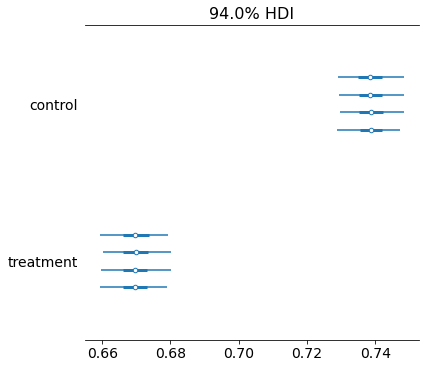

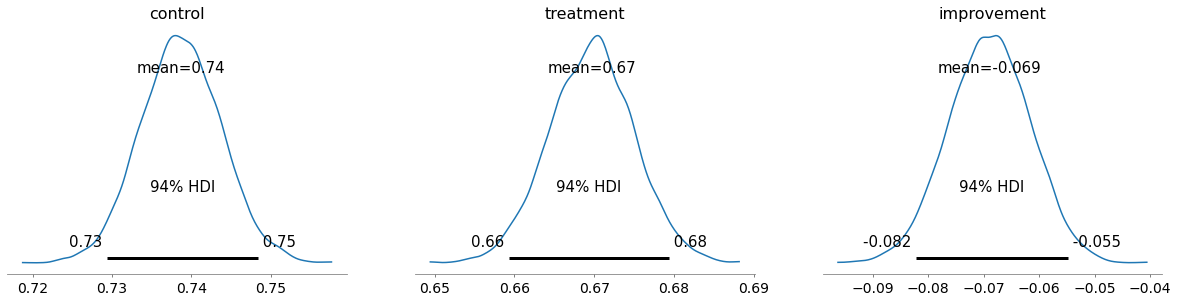

In [54]:
summary_oa, trace_oa = bayesian_ab(cont, treat, 'over_one_percent', 'bernoulli', 'reduce', 'All companies overspend probability control vs treatment')

-------------------------------------------------------
All companies overspend ratio control vs treatment
-------------------------------------------------------
Probability of beating control: 100.0%
Expected loss of choosing control: 0.03, treatment: 0.0


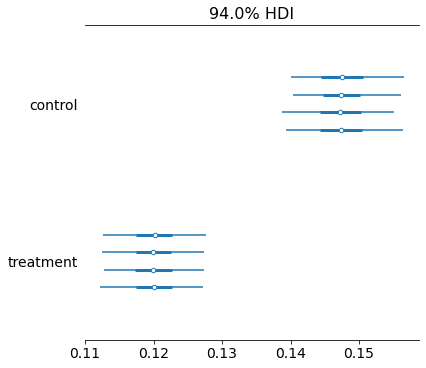

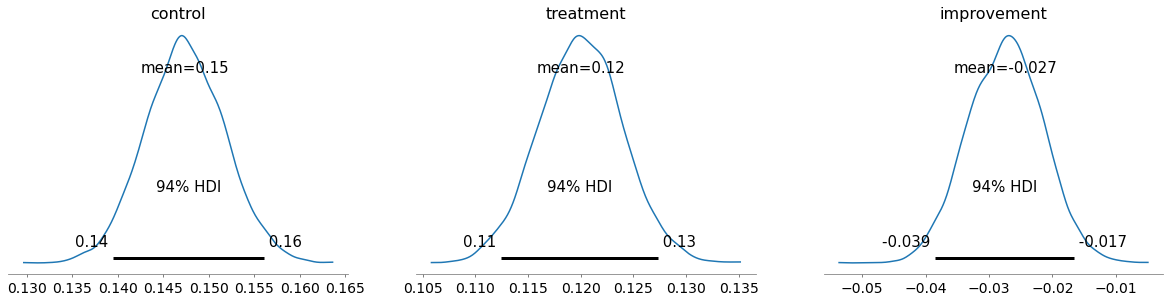

In [55]:
summary_ra, trace_ra = bayesian_ab(cont, treat, 'overspend_ratio', 'poisson', 'reduce', 'All companies overspend ratio control vs treatment')

-------------------------------------------------------
All companies campaign budget control vs treatment
-------------------------------------------------------
Probability of beating control: 100.0%
Expected loss of choosing control: 733.42, treatment: 0.0


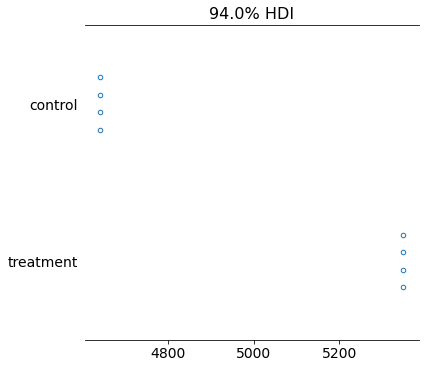

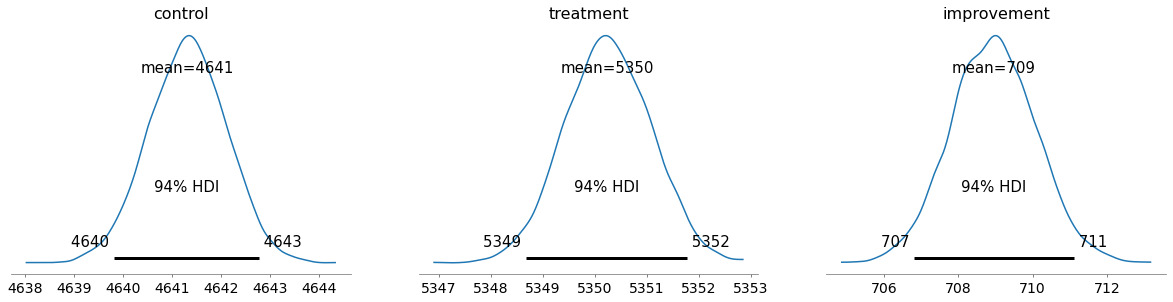

In [56]:
summary_ba, trace_ba = bayesian_ab(cont, treat, 'campaign_budget', 'poisson', 'increase', 'All companies campaign budget control vs treatment')

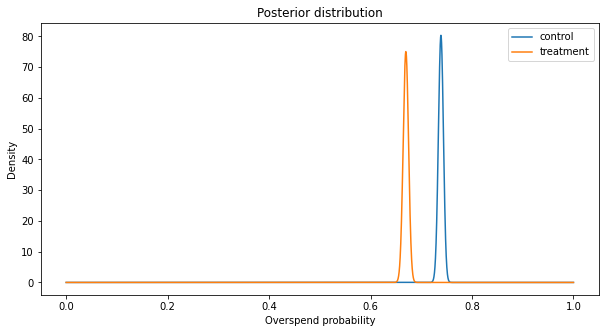

In [57]:
n_c, n_t = cont['over_one_percent'].count(), treat['over_one_percent'].count()
true_c, true_t = cont['over_one_percent'].sum(), treat['over_one_percent'].sum()
false_c, false_t = n_c - true_c, n_t - true_t

# Take mean value as parametors 
alpha_m, beta_m = summary_oa.loc['alpha','mean'], summary_oa.loc['beta','mean']

# Draw posterior distribution
cont_pos = b(true_c + alpha_m, false_c + beta_m)
treat_pos = b(true_t + alpha_m, false_t + beta_m)

fig, ax = plt.subplots(figsize=(10,5))
x = np.linspace(0,1,5000)
ax.plot(x, cont_pos.pdf(x), label='control')
ax.plot(x, treat_pos.pdf(x), label='treatment')
ax.set_xlabel('Overspend probability')
ax.set_ylabel('Density')
ax.set_title('Posterior distribution')
ax.legend()

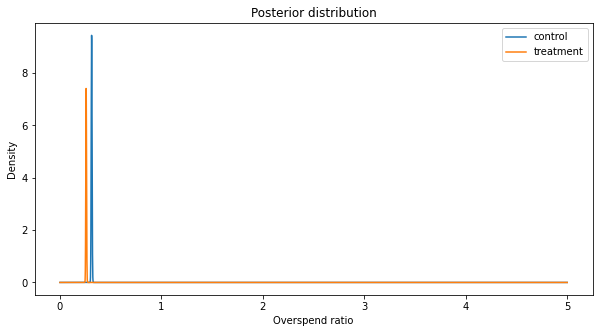

In [58]:
# Take mean value as parametors 
k_m, theta_m = summary_ra.loc['k','mean'], summary_ra.loc['theta','mean']
ratio_c, ratio_t = cont.overspend_ratio.mean(), treat.overspend_ratio.mean()

# Draw posterior distribution
cont_pos = gamma(a=(true_c + k_m), scale=(theta_m / (1 + theta_m * true_c * ratio_c)))
treat_pos = gamma(a=(true_t + k_m), scale=(theta_m / (1 + theta_m * true_t * ratio_t)))

fig, ax = plt.subplots(figsize=(10,5))
x = np.linspace(0,5,5000)
z = [1/i for i in x] # Average overspend ratio
ax.plot(x, cont_pos.pdf(z), label='control')
ax.plot(x, treat_pos.pdf(z), label='treatment')
ax.set_xlabel('Overspend ratio')
ax.set_ylabel('Density')
ax.set_title('Posterior distribution')
ax.legend()

## Large companies <a class="anchor" id="bayesian-large"></a>

-------------------------------------------------------
Large companies overspend probability control vs treatment
-------------------------------------------------------
Probability of beating control: 100.0%
Expected loss of choosing control: 0.23, treatment: 0.0


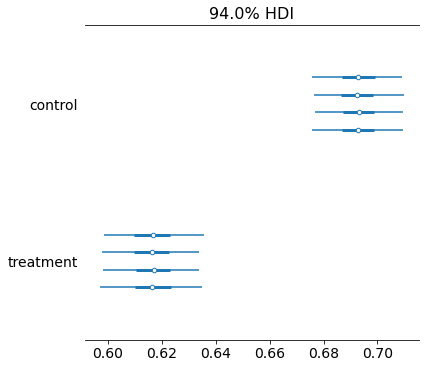

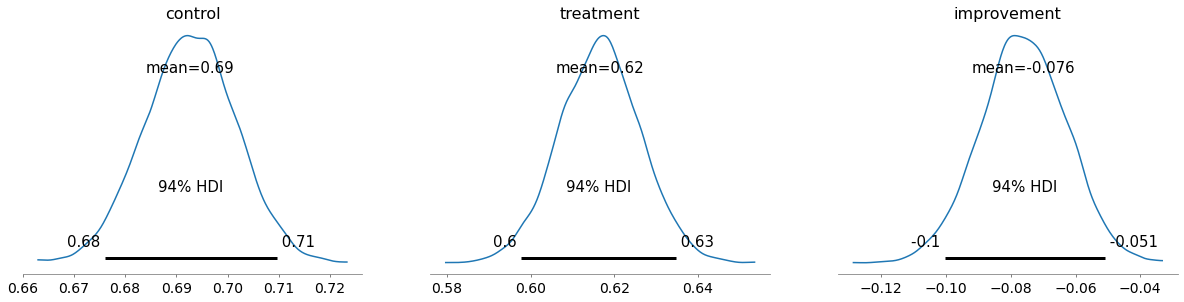

In [59]:
summary_ol, trace_ol = bayesian_ab(cl, tl, 'over_one_percent', 'bernoulli', 'reduce', 'Large companies overspend probability control vs treatment')

-------------------------------------------------------
Large companies overspend ratio control vs treatment
-------------------------------------------------------
Probability of beating control: 100.0%
Expected loss of choosing control: 0.1, treatment: 0.0


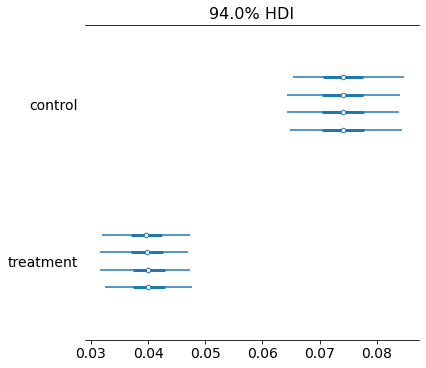

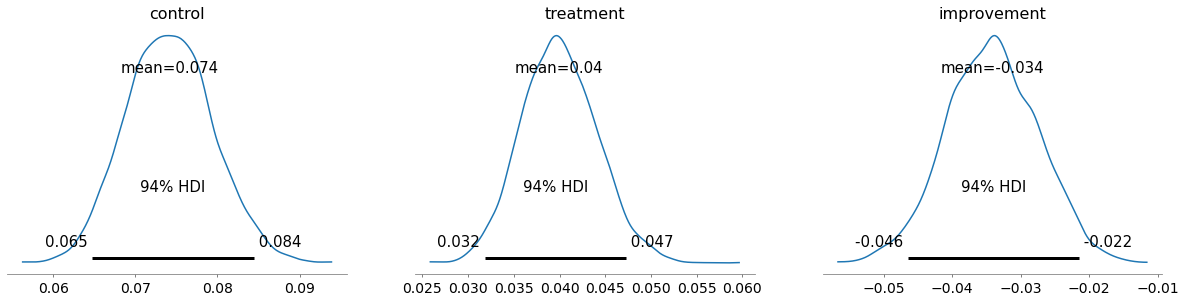

In [60]:
summary_rl, trace_rl = bayesian_ab(cl, tl, 'overspend_ratio', 'poisson', 'reduce', 'Large companies overspend ratio control vs treatment')

-------------------------------------------------------
Large compannies campaign budget control vs treatment
-------------------------------------------------------
Probability of beating control: 100.0%
Expected loss of choosing control: 19908.82, treatment: 0.0


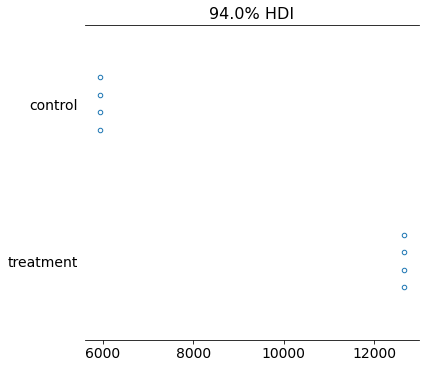

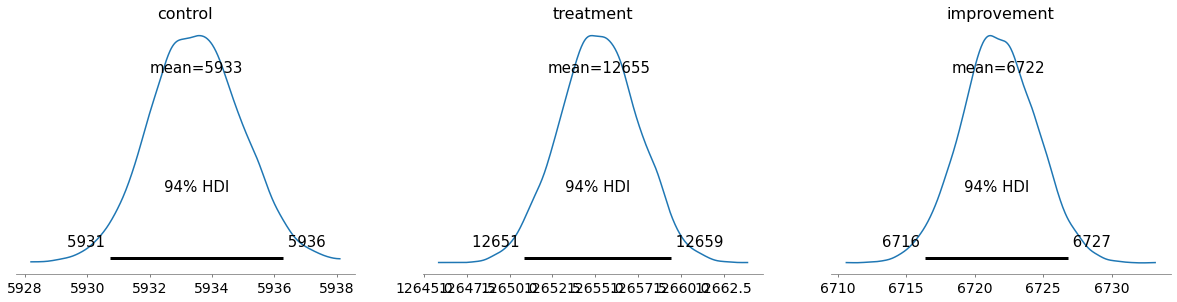

In [61]:
summary_bl, trace_bl = bayesian_ab(cl, tl, 'campaign_budget', 'poisson', 'increase', 'Large compannies campaign budget control vs treatment')

## Medium companies <a class="anchor" id="bayesian-medium"></a>

-------------------------------------------------------
Medium companies overspend probability control vs treatment
-------------------------------------------------------
Probability of beating control: 73.75%
Expected loss of choosing control: 0.21, treatment: 0.04


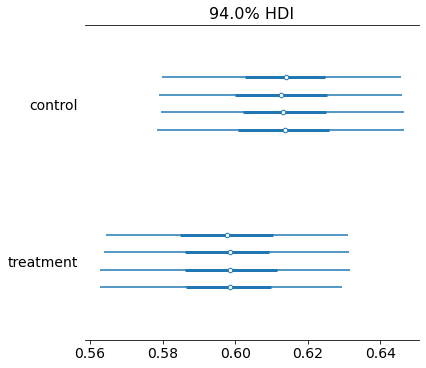

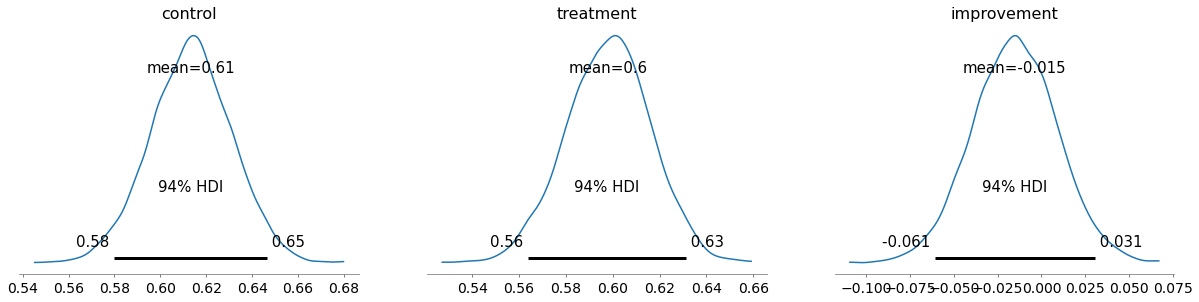

In [62]:
summary_om, trace_om = bayesian_ab(cm, tm, 'over_one_percent', 'bernoulli', 'reduce', 'Medium companies overspend probability control vs treatment')

-------------------------------------------------------
Medium companies overspend ratio control vs treatment
-------------------------------------------------------
Probability of beating control: 23.1625%
Expected loss of choosing control: 0.02, treatment: 0.11


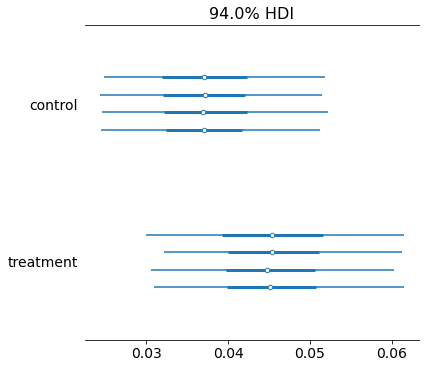

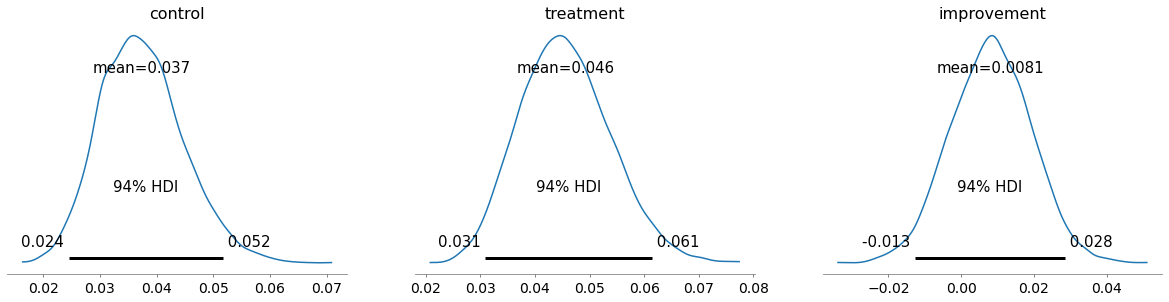

In [63]:
summary_rm, trace_rm = bayesian_ab(cm, tm, 'overspend_ratio', 'poisson', 'reduce', 'Medium companies overspend ratio control vs treatment')

-------------------------------------------------------
Medium companies campaign budget control vs treatment
-------------------------------------------------------
Probability of beating control: 0.0%
Expected loss of choosing control: 0.0, treatment: 20002.85


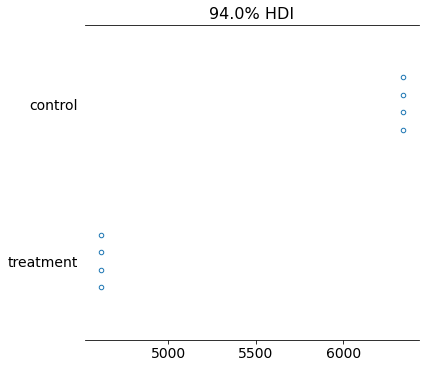

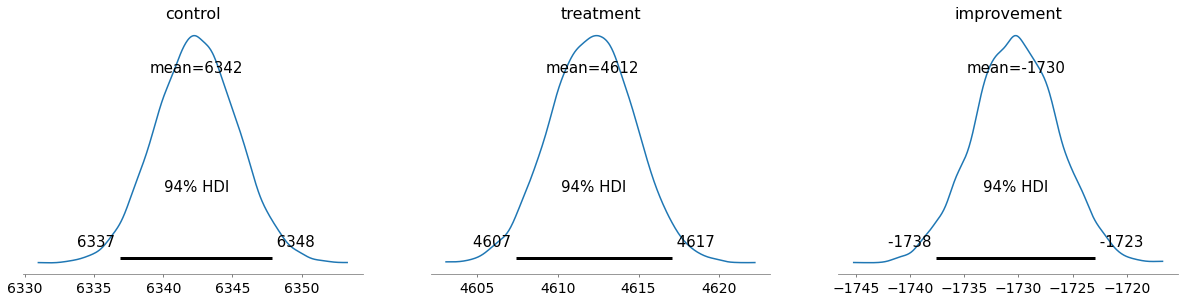

In [64]:
summary_bm, trace_bm = bayesian_ab(cm, tm, 'campaign_budget', 'poisson', 'increase', 'Medium companies campaign budget control vs treatment')

## Small companies <a class="anchor" id="bayesian-small"></a>

-------------------------------------------------------
Small companies overspend probability control vs treatment
-------------------------------------------------------
Probability of beating control: 100.0%
Expected loss of choosing control: 0.15, treatment: 0.0


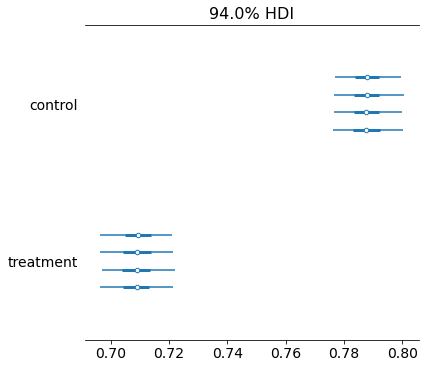

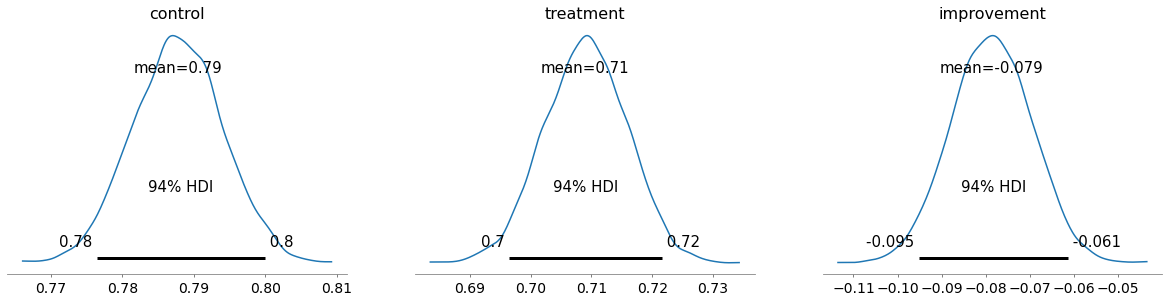

In [65]:
summary_os, trace_os = bayesian_ab(cs, ts, 'over_one_percent', 'bernoulli', 'reduce', 'Small companies overspend probability control vs treatment')

-------------------------------------------------------
Small companies overspend ratio control vs treatment
-------------------------------------------------------
Probability of beating control: 100.0%
Expected loss of choosing control: 0.07, treatment: 0.0


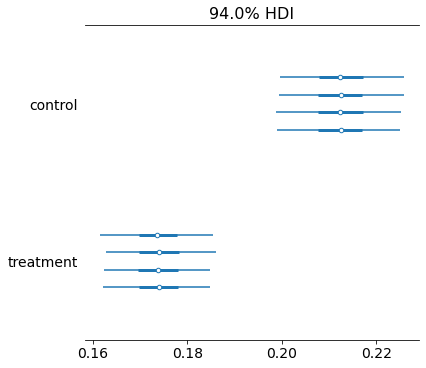

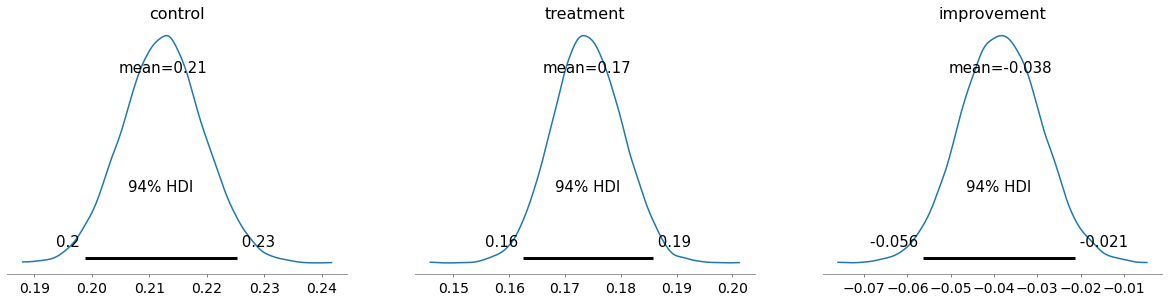

In [66]:
summary_rs, trace_rs = bayesian_ab(cs, ts, 'overspend_ratio', 'poisson', 'reduce', 'Small companies overspend ratio control vs treatment')

-------------------------------------------------------
Small companies campaign budget control vs treatment
-------------------------------------------------------
Probability of beating control: 0.0%
Expected loss of choosing control: 0.0, treatment: 3393.91


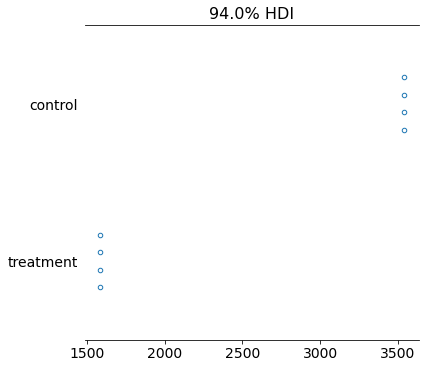

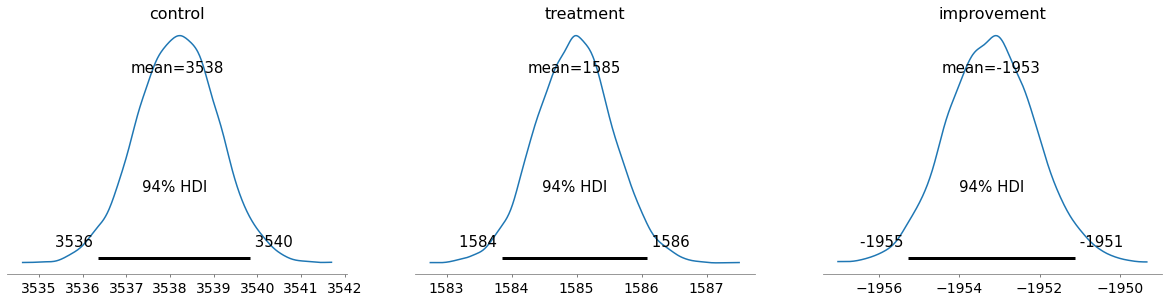

In [67]:
summary_bs, trace_bs = bayesian_ab(cs, ts, 'campaign_budget', 'poisson', 'increase', 'Small companies campaign budget control vs treatment')